In [274]:
from sklearn import metrics, preprocessing
from collections import defaultdict
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import itertools as it
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
import adaptive_confound.utils as acu

In [275]:
sns.set(style="whitegrid", context="paper")

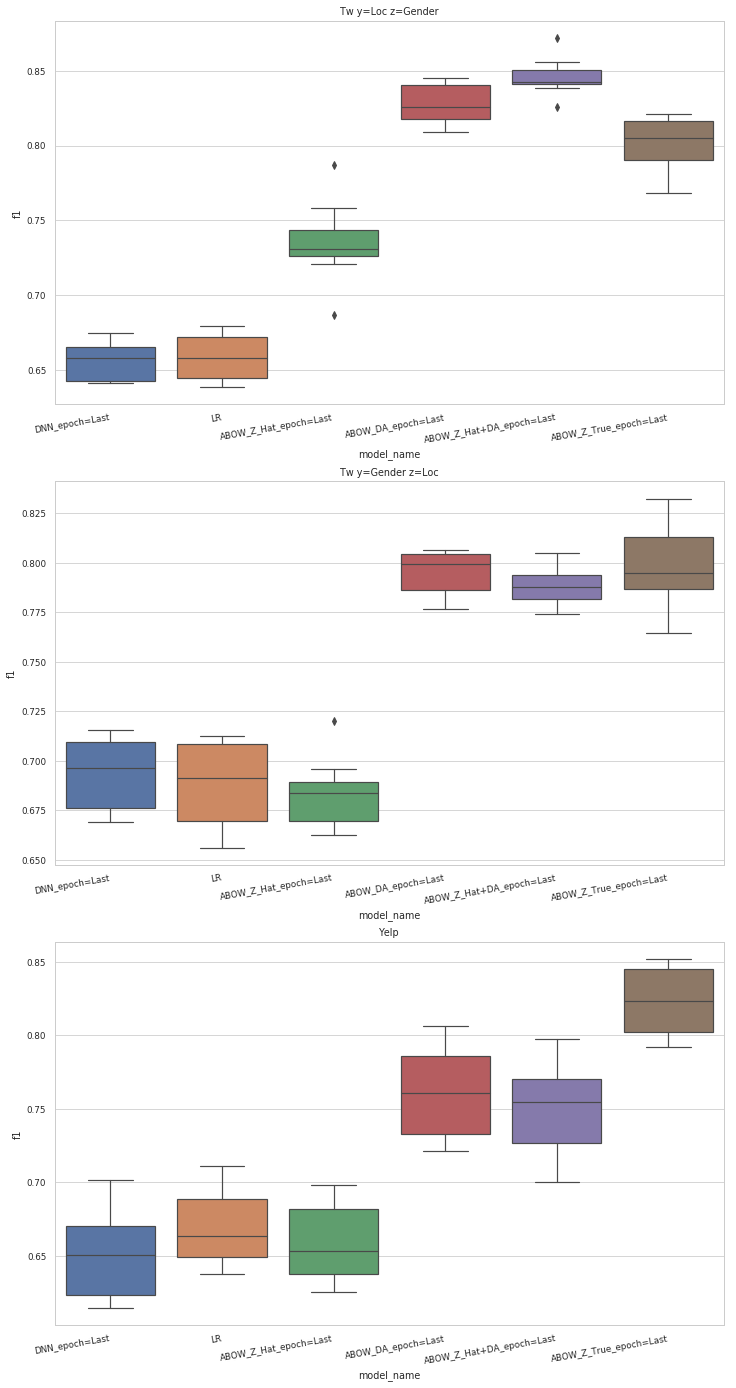

In [422]:
df = pd.read_json("./abow_benchmark_sdg_test.jsonl", orient="records", lines=True)
df["corr_diff"] = np.around(df.tr_corr - df.te_corr, 1)
df["f1"] = df.apply(lambda r: metrics.f1_score(r.ytrue, r.ypred), axis=1)
df = df[(df.model_selection.isnull()) | (df.model_selection == "Last")]
def make_name(r):
    if pd.isna(r.model_selection):
        return r.model
    else:
        return "{}_epoch={}".format(r.model, r.model_selection)
df["model_name"] = df.apply(make_name, axis=1)

n_datasets = df.dataset.nunique()
fig, ax = plt.subplots(n_datasets, sharex=False, figsize=(12, n_datasets*8))
order = df.groupby("model_name").mean().f1.sort_values().index.tolist()
# order = ["DNN", "LR", "ABOW_Z_Hat", "ABOW_DA", "ABOW_Z_Hat+DA", "ABOW_Z_True"]

for i, dname in enumerate(df.dataset.unique()):
    dfi = df[df.dataset==dname]
    axi = ax[i] if n_datasets > 1 else ax
    sns.boxplot("model_name", "f1", data=dfi, ax=axi, order=order)
    axi.set_title(dname)
    axi.set_xticklabels(axi.get_xticklabels(), rotation=10, ha="right")
fig.savefig("benchmark_sgd.png", bboxes_inches="tight")

Tw y=Loc z=Gender
Tw y=Gender z=Loc
Yelp


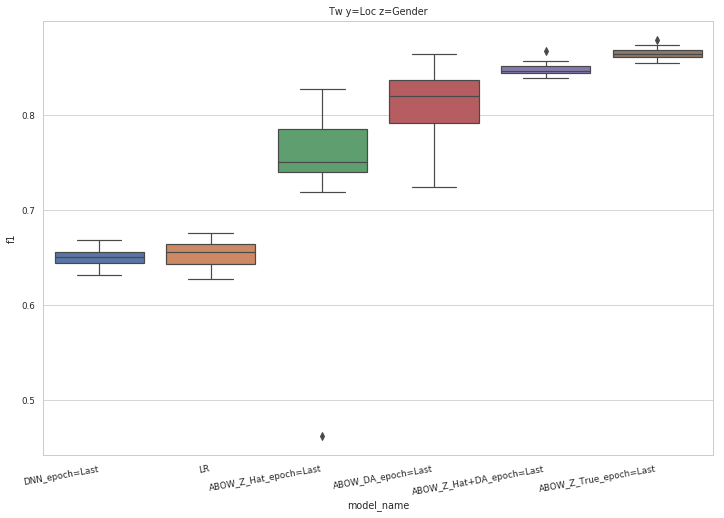

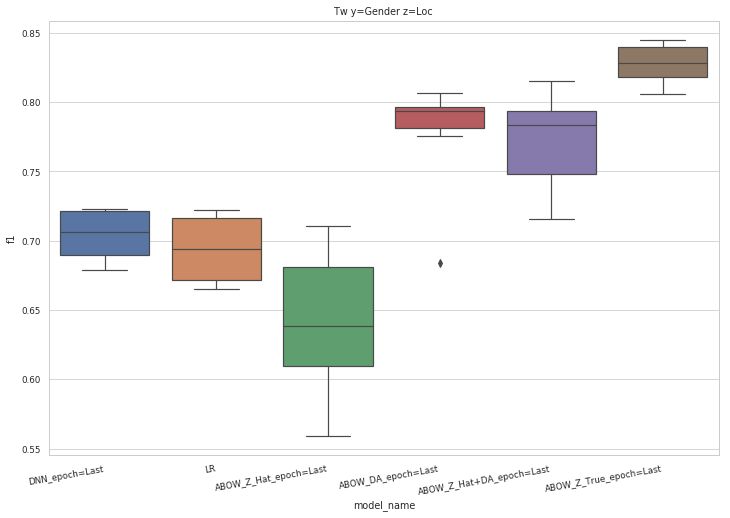

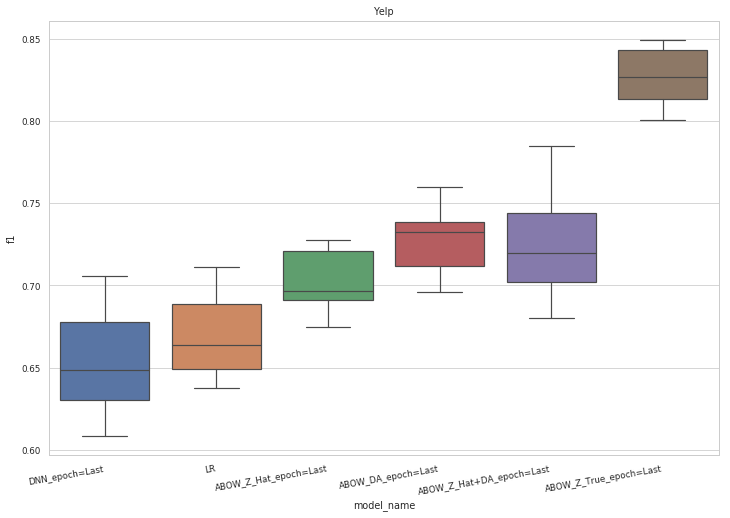

In [293]:
df = pd.read_json("./abow_benchmark_sgd_more.jsonl", orient="records", lines=True)
df["corr_diff"] = np.around(df.tr_corr - df.te_corr, 1)
df["f1"] = df.apply(lambda r: metrics.f1_score(r.ytrue, r.ypred), axis=1)
df = df[(df.model_selection.isnull()) | (df.model_selection == "Last")]
def make_name(r):
    if pd.isna(r.model_selection):
        return r.model
    else:
        return "{}_epoch={}".format(r.model, r.model_selection)
df["model_name"] = df.apply(make_name, axis=1)

n_datasets = df.dataset.nunique()
order = df.groupby("model_name").mean().f1.sort_values().index.tolist()
# order = ["DNN", "LR", "ABOW_Z_Hat", "ABOW_DA", "ABOW_Z_Hat+DA", "ABOW_Z_True"]

for i, dname in enumerate(df.dataset.unique()):
    print(dname)
    fig, ax = plt.subplots(figsize=(12, 8))
    dfi = df[df.dataset==dname]
    groups = dfi.groupby("model_name")
#     print(groups.f1.mean())
#     print(groups.f1.std())
#     print()
    sns.boxplot("model_name", "f1", data=dfi, ax=ax, order=order)
    ax.set_title(dname)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=10, ha="right")
    fig.savefig("benchmark_sgd_{}.pdf".format(dname), bboxes_inches="tight")

In [425]:
from IPython.display import display, HTML

def get_word_importance_diff(df, k=30, wrap=6):
    for i, dname in enumerate(df.dataset.unique()):
        print(dname)
        dfi = df[df.dataset == dname]
        models = np.sort(np.unique(dfi.model))
        models = [ _ for _ in models if _ != "LR"]
        fts = np.array(dfi.iloc[0].features)
        r = defaultdict(lambda: defaultdict(lambda: ""))
        for m1, m2 in it.product(models, models):
            if m1 == m2:
                continue
            w1 = dfi[dfi.model == m1].preproc_wi
            w2 = dfi[dfi.model == m2].preproc_wi
            dists = []
            for wi1, wi2 in zip(w1, w2):
                dists.append(np.abs(wi1) - np.abs(wi2))
            dists = np.vstack(dists).mean(axis=0)
            order = dists.argsort()[::-1][:k]
            for subarr in np.array_split(order, k//wrap):
                r[m1][m2] += " ".join(fts[subarr]) + "\n"
        rdf = pd.DataFrame(r)
        display( HTML(rdf.to_html().replace("\\n", "<br>")) )

In [429]:
df["preproc_wi"] = df.word_importance.apply(lambda wi: preprocessing.minmax_scale(wi, (-1,1)))
df["preproc_wi"] = df.word_importance.apply(lambda wi: preprocessing.scale(wi))

get_word_importance_diff(df, 100, wrap=5)

Tw y=Loc z=Gender


,ABOW_DA,ABOW_Z_Hat,ABOW_Z_Hat+DA,ABOW_Z_True,DNN
ABOW_DA,NaN,nails hubby makeup yay fastestbros heels bottle lipstick decadesnecessary seth fellas mixed ski3rd xoxo ft matters sumsstaying causewereguys omg cute maintuesdays ford chase case buzzfeedear xd warehouse haunted turkeyugh tables jonathan messed tieanybody lion clay necklace gainmeditation understands mar montana cupsslip wet awaits justin budlayer convos bro gays ceaseals pussy citizens brett backssunshine adorable purchase bust shouldafamilies caring speed sales createfam somewhat freddyamazin proceeds preachpolar packing checkout roomie excitedhuffingtonpost yolo youth denial youuuuwi smiles vines joey cupcakeshomies cozy standing rack wonderful,liquor dunkin familiar savage grabbingpress sums ughhh comfortable freddyamazintreated haunted behalf sticks assumeeli maryland sacrifice leak beatingantonio buds steps lately pornconvos labor snowing rap commonwhitegiriyouuuu jessica windy updated speakswright numb cozy tables sweatpantsfastest gallery passport nation claymeat cheap clubs pets siribill reportedly kissing cups swapfreeway ima mommy wondering deliversshoulda refuses decades havin whofficer netflix 13th breakdown comfyrob mask daughters losers scheduledtag diabetes ft pushing unitbuses evidence actions alice resultnorthern salad complaints unreal giftedandrew midterm pastor matters bryanflip charging brb tires purpose,horny fastest 61 cinnamon savesjared eyed luke downs tastytransportation panda ski lobster soonerwindy meditation supportive ppl 77beaches eagle sweater rack meganpromise packages engage spill creativitycontract pepsi rebuild regularly programsrats grandpa newly pudding shadowscanada charm paranoid jill oddspumping kardashian william slices mutualadults pirate renewed holly worthyfeature nofilter emma inspirational audiunit eats 7am simon 59hart lennon seth lion discoveredchickens frustration smack government electedkissing mountain tavern basics seedac lighter besties parallel kindnessgirly strongest eli cheesy sticksftw margarita divine asses jonathandebt tuesdays keeper 1989 registered,nails yay makeup cute wonderfulbro bottle adorable hubby 3rdomg xoxo heels bros husbandfrozen sir cried seth excitedla roomie understands pinterest createslip case bust packing fellasppl necessary pls families standingft boyfriend sister ski lionmap dress bud main ughsales gossip fam haters bffstaying lipstick starter fastest closetsunshine cousin chill idiot womanshops records causewereguys necklace birdcaring congratulations announce 300 brettjournalism showing throw strawberry lukesums experience eats bought waitingpace anxiety rack student contractpets online wi refuses tiemidnight jonathan noodle legend completelybreathe bestie cups puppy daughter
ABOW_Z_Hat,dodger earthquake angeles manhattan stapleschargers nj drought williamsburg yankeescoast los newyork diego brooklynstaten sandy studios mets lakingsobservatory anaheim coachella burbank dodgersyankee academy raiders venice yorkerjeter laker storm basement subwaysf pacific bay bk caliyorkers ca losangeles marathon disneylandglendale laguardia citi abc7 torontosocal taco roads queens bronxpatrick charlie atlantic huh prospectmidtown francisco az island barbarajersey san tacos sunglasses squareusc vista griffith hawaii paconanobrien coney transit syracuse 49ersgriffin harlem jess letter mta12th snowy ucla ny coatbucks nyu penn contacts upstateballroom workers cab button ave,NaN,angeles dodger nj earthquake sandystaples drought anaheim lakings burbankstaten mets manhattan diego newyorkchargers dodgers ucla coachella brooklynwilliamsburg disneyland sf studios raidersusc los venice glendale yankeesyankee socal yorkers pacific yorkercali laker basement grove franciscoabc7 ca queens jersey roadsfreeway losangeles laguardia transit observatoryclippers vegas florida island stormboston marathon coast bk ferryconanobrien hawaii citi lakers calbarbara 49ers vista train kobebryantupstate pa academy nyu familiarhuh 

Tw y=Gender z=Loc


,ABOW_DA,ABOW_Z_Hat,ABOW_Z_Hat+DA,ABOW_Z_True,DNN
ABOW_DA,NaN,disneyland freeway monica angeles dodgersearthquake ucla brooklyn nj cany california los socal blizzardhollywood lax disease nyc snowingvenice hills usc burbank snowblvd tn san manhattan dangmalibu latimes disgusting dunkin harlemcal york trends jennifer ducksabc7 louis florida messages lakers405 grove shout sf williamsburgevolution tru hike jersey tacossandy pasadena shaving pacific visionmetropolitan anaheim forgiveness restaurants tradedupstate court dtla log idknc haircut losangeles plays layorkers immune mta chad pittnewark battles equipment boba actualnope island coco bk headedktla canyon huh ave vegasmexico disappoint newyork autocorrect drought,haircut bros evolution selfies dmvclutch twin recommend tru perfectionbarber ana messed shaving thousandmeninisttweet kardashian shout dip drugsporn reg chasing recognized roughgoodnight license ignorant gentleman presentationdebt condoms julie ducks convincedears closet teenage ellen billionreplied earthquakes reference beyonce na97 blizzard retweets slept hostingchampagne dang smash internet freewayquietly homies safari chemistry pocketsbrad idk cheerleader lauren immaturematch maya gps meditation valentinenerdy lmaooo 64 christopher pressktla gov alright registration shocktrio site deer 2005 simplecoolest hugh pacific 3000 admitucla mock gym fr frieslakings surrender 76 knocked region,disappoint presidential pause roadtrip directlywelp coat wk fridge candlecloses closest rd villa alleyunhappy trusted additional tavern pirateeyed soldiers grave searching jackiesuffer bug header kenny shacktriple pancake familiar cure woodencontinuing supported woken halfway bladehardcore debating beans log breezehandled unit cocky petty hopjared scenes josh rated busescarrying nationwide massachusetts md chargergrove robinson girlfriends moore screamorganized sipping couch grown trucolorful value jess eli dvdpopping actual surrounding tanning roadsrichard dove 110 dating downstshirt politics tattoos morris mashshaving residents treadmill chem cheatingroosevelt funnyvines moved gracias overly,disneyland angeles monica california nycny earthquake nj brooklyn cadodgers los hollywood san hillsucla venice socal snow freewayblizzard snowing york manhattan laxla blvd usc cal floridalakers island malibu jersey sandyburbank sf subway newark abc7dunkin yankee broadway yankees burritostaten seattle anaheim santa groveboba williamsburg hike losangeles pacifictacos latimes 405 dang studiosbk tn newyork vegas harlemyorkers messages huh francisco escapeshooting mexican griffith mta canyonvalley court upstate louis bronxlovewins nc southern dtla unionqueens disgusting sushi church alsodisease vision means worries pasadenadirectly 24 mess panda button
ABOW_Z_Hat,fave cap starter government jonesshots depth saints hallelujah happierdresses banana youuuu colors forgiveadults 300 outfit normal decenteaten ummmm furious indiana suitpregnant pushing compliment loveit championshipyesssss obsessed accent boo heatencourage gif ppl championships unexpectedunderstands headache baking married creepkisses league cried 10x barbierefs sheets lips pour hangingnaturally roomie mlb neither ltlibrary bestfriends umm tiger minessecretly stranded sort solar anxiousflag sexual sista madden reminderama sugar 65 row brapresents leaked resource awww happiestpajamas anna pinterest draft raidersparis land republican brandon stresssnacks anxiety gifts commonwhitegiri painful,NaN,fave colors outfit bra encourageshots pushing furious government selfieshappiest maya starter conspiracy dresseshallelujah adults cap pjs brideclutch heels creep jones pornoitnb roomie obsessed gifts lipscloset reminder redemption resource championshipama decent muscle notebook anxietyposter opportunities secretly albert sistamessy dressed woridstarhlphop victoria sausageesp dunk banana ross champagnenormal indiana cried empty buckslauren jonathan depth yesssss minesanxious youuuu cloud baking pourpre

Yelp


,ABOW_DA,ABOW_Z_Hat,ABOW_Z_Hat+DA,ABOW_Z_True,DNN
ABOW_DA,NaN,coffee dinner menu restaurant foodpizza job heard eat insuranceappointment flavor steak meat drivegame higher chain right suggestfurniture wine cut company nontacos salads produce waitress locationfries hair dining sushi generousfree tables suggested cheese pastacasual hot hostess room tenderburger clothes ride help nailssauce eggs sat kids donutslower waiter view pho eatingchicken orders original rice membershippancakes eaten gotta wait storeton rooms taco works averagefresh online aside pool elevatoraddition phenomenal mall doing brewspending work facility salon salsasandwich dried strip venue flavorfulnail spend main week bland,suggested soggy review disgusting pittmeant eating complaint explanation flightstattoo game finding starbucks teriyakitreat mussels expensive key donutsincredible thorough wasnt sports shortschool truck noon alternative driveelevator pub furniture company onlineinsurance stinks original topped heardbooks filthy cut wouldnt inspiredcons size shared cluster phenomenaltops cheesecake warehouse relief touristdaughter including tickets ready pmperiod individual complaints sub gelimagined tires pretty mediocre yaytuesday brulee tots trick possibledine antique membership dried police26 necessary mellon skip organicmix slice dined lower crabburgh sausage increase lively funnypulling works camera winter rotation,noon provides topped luckily inexpensivetab phenomenal mins ipa happeningaddition surprise gooski freshly softdiscovered higher suggested flagged providingacted lavender goodwill complimented artshi enter establishments brand insuranceknown visits count tap accounttakeout mile shared student headachebrands mothers questionable desert alrightjoe merchandise thinking drawn elizabethlobster sharing adventurous dude catsirritated rated putting highlight tendervideo thumbs shows hundreds ncdamage member valet gift mechanicreceive mussels stellar properly sleptbegan complain gotta speciality sicilianmex feet quantity requested flyercoaches personally destination ham minormenus mats switching treating dietencounter settled afternoons attempt energy,coffee menu job dinner restauranteat food flavor appointment pizzameat chicken right steak cheesehigher wine heard location furniturecasual fries room drive insurancecompany fresh chain salads hairhelp cut game sauce tablesride hostess store salon kidspasta salad rice sat calleddining hot doing wait worksushi non sandwich waitress eggsweek suggested tender works tacofree tacos clothes rooms okorder burger lower generous thingoffice fruit gotta suggest nailsserver waiter pool flavorful luncheaten average spend pancakes viewvenue try aside pho originalgiven weeks orders placed courseelevator served tell entrees tasted
ABOW_Z_Hat,asked supposed shouldn enjoyed endedcharge rude perfectly helpful makesallowed ask evening customers nastyleft spicy correctly management toldinformed leaving counter happened frustratingpark light definitely minutes relaxamazing corner enjoyable caring sawcomplained glad wonderful total friendsbring courtesy woman patrons uptowndog local delish suppose cleansuper crispy manager trails piecesreviews fine spacious refuse cheeseswest recommend dry worst mistakelevel ranch knowledgeable neighborhood efficienthouse gorgeous favorite 60 workoutchowder refused hipster halfway policekind support pan lost unacceptableloves unprofessional leave round brokewanted cooked variety refill highlydelightful little visit mention classes,NaN,supposed perfectly shouldn charge allowedcorrectly rude makes spicy nastyasked enjoyable police enjoyed caringhelpful ended frustrating management eveningcomplained process delish round courtesyrelax happened chowder headed earliersupport suppose wouldnt funny possiblehipster flights fabulous leaving basketballwaxing informed disappoint ask trailsforced smokey dry neighborhood downtownsauces bartenders gorgeous ranch cornersmelled plan helps refused counterwoma

In [294]:
import adaptive_confound.utils as acu

In [295]:
d = acu.read_pickle("/data/virgile/confound/adaptive/in/twitter_dataset_y=location_z=gender.pkl")

/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.19.0 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.19.0 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [301]:
from scipy.stats import pearsonr
from tqdm import tqdm
import scipy.sparse as sp

def get_correls(X, y, verbose=0):
    """
    correlations of X and y
    """
    y = np.array(y)
    X_issp = sp.issparse(X)
    safe_X = X
    if X_issp:
        safe_X = X.toarray()
        
    r = []
    loop = range(safe_X.shape[1])
    if verbose:
        loop = tqdm(loop)
    for i in loop:
        check_empty = np.all(safe_X[:,i] == 0) or np.all(y == 0)
        v = 0 if check_empty else pearsonr(safe_X[:,i], y)[0]
        r.append(v)
    return np.array(r)

In [302]:
xz_corr = get_correls(d.X, d.z, 1)

100%|██████████| 21981/21981 [00:10<00:00, 2056.70it/s]


In [307]:
top_z_features = np.square(xz_corr).argsort()[::-1]

In [308]:
df.dataset.unique()

array(['Tw y=Loc z=Gender', 'Tw y=Gender z=Loc', 'Yelp'], dtype=object)

Tw y=Loc z=Gender


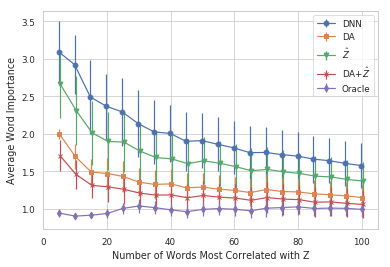

In [419]:
from IPython.display import display, HTML
df["preproc_wi"] = df.word_importance.apply(lambda wi: preprocessing.scale(wi))

markers = ['o', 's', 'v', 'x', 'd']
fig, ax = plt.subplots(figsize=(6,4))
for i, dname in enumerate(['Tw y=Loc z=Gender']):
# for i, dname in enumerate(['Tw y=Gender z=Loc']):
    print(dname)
    dfi = df[(df.dataset == dname)]
#     dfi = df[(df.dataset == dname) & (df.corr_diff == 1.6)]

    models = np.sort(np.unique(dfi.model))
    models = [ _ for _ in models if _ not in ["LR"]]
    fts = np.array(dfi.iloc[0].features)
    r = defaultdict(lambda: defaultdict(lambda: ""))
    jitter = np.random.normal(scale=.25, size=len(models))
    name_map = {
        "ABOW_DA": "DA",
        "ABOW_Z_Hat+DA": "DA+$\hat{Z}$",
        "ABOW_Z_True": "Oracle",
        "DNN": "DNN",
        "ABOW_Z_Hat": "$\hat{Z}$"
    }
    models = ["DNN", "ABOW_DA", "ABOW_Z_Hat", "ABOW_Z_Hat+DA", "ABOW_Z_True"]
    for m, mark, jitt in zip(models, markers, jitter):
        xp, yp, errp = [], [], []
        for k in np.linspace(5, 100, 20):
            w = np.vstack(dfi[dfi.model == m].preproc_wi)[:,top_z_features]
            w = np.abs(w).mean(axis=0)[:int(k)]
            xp.append(k+jitt)
            yp.append(w.mean())
            errp.append(.5*w.var())
        ax.errorbar(xp, yp, errp, marker=mark, label=name_map[m], alpha=1, )
    ax.set_xlabel("Number of Words Most Correlated with Z")
    ax.set_ylabel("Average Word Importance")
    plt.legend()
    fig.savefig("top_k_avg_word_importance.pdf", bbox_inches="tight")

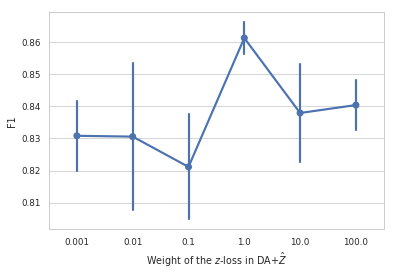

In [506]:
df = pd.read_json("./abow_benchmark_sgd_sensitivity.jsonl", orient="records", lines=True)
z_loss_vals = np.tile( np.array([.001, .01, .1, 1, 10, 100]), 20 )
df2 = df[(df.model_selection == "Last")]
# df2["z_loss_val"] = z_loss_vals[:df2.shape[0]]
df2["f1"] = df2.apply(lambda r: metrics.f1_score(r.ytrue, r.ypred), axis=1)

fig, ax = plt.subplots(figsize=(6,4))
sns.pointplot("z_loss_val", "f1", data=df2, ax=ax, ci="sd",)
ax.set_ylabel("F1")
ax.set_xlabel("Weight of the $z$-loss in DA+$\hat{Z}$")
fig.savefig("z_sensitivity.pdf", bbox_inches="tight")

In [498]:
!date

Fri Oct 12 22:42:31 PDT 2018
